(c) Merten Stender, Hamburg University of Technology, Dynamics Group (www.tuhh.de/dyn), m.stender@tuhh.de

# IV-B: Explain thickness factor


in the CV model architecture study we found out that only the sample thickness and the operator are factors that can be robustly predicted from the absorption measurement curves. Hence, we can only explain those models.

We will train a final model, then gather all correct + highly confident model predictions, and compute the corresponding SHAP values for an illustrative example


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shap as shap
import pickle as pickle
from matplotlib import pyplot as plt
import os
import shutil

shap.initjs() # enable graphics for shap

import utils as utils

# versioning
print('Numpy: ' + np.version.version)        # should be 1.17.0
print('SHAP: ' + str(shap.sys.api_version))  # should be 1013
print('tensorflow: ' + tf.__version__)       # should be 2.3.0

Numpy: 1.17.0
SHAP: 1013
tensorflow: 2.3.0


### model selection

In [2]:
# define the factors and model parameters for the model to explain.
factor_name = 'thickness'  # height OR manufacturer. All other models are not performing well
n_features = 196           # select the sampling / feature dimensionality reduction rate
model_name = 'baseline'    # classification model

# some training parameters
n_epochs = 50
n_batch = 64

cur_path = factor_name + '_' + str(n_features) + '_' + model_name

In [3]:
# load the input and output data
X, y, _, f = utils.load_data(n_features)

# prepare for trainnig another (final) model
X_train, X_test, y_train, y_test, class_names = utils.prepare_data_univariate(X, y, quant=factor_name, cv_flag=False)

n_outputs = y_train.shape[1]
print('number of classes ( = number of outputs): ' + str(n_outputs))

number of factors: 20
removed 6 all-negative samples
number of measurements: 3073
number of frequency points: 196
number of classes ( = number of outputs): 4


### train the final model

in the final configuration, and vaidate against test set. 



In [4]:
model = utils.build_model(model_name, n_features, n_outputs, multilabel_flag=False)
model, history, test_acc = utils.train_evaluate_model(model, 
                                                      epochs=n_epochs, batch_size=n_batch,
                                                      X_train=X_train, X_test=X_test,
                                                      y_train=y_train, y_test=y_test)

# save model
try:
    os.mkdir(cur_path)
except:
    print('folder exists')
    
try:
    os.remove(cur_path + '/tf_model_final.h5')
except:  
    print('no model exists')
    
model.save(cur_path + '/tf_model_final.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 196)               38612     
_________________________________________________________________
dense_1 (Dense)              (None, 98)                19306     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4950      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 104       
Total params: 64,247
Trainable params: 64,247
Non-trainable params: 0
_________________________________________________________________
Train: 1.000, Test: 1.000
folder exists


In [5]:
# get the model predictions for the complete data set
X = np.concatenate([X_train, X_test])  # all input data samples
y = np.concatenate([y_train, y_test])  # ground truth labels
y_pred = model.predict(X)  # invoke the model, make predictions for all samples

# get the data samples with correct predictions AND confidence >0.9
X_conf, y_conf = utils.get_high_confidence_predictions(y, y_pred, X, conf=0.9)

(3073,)
Confidence >0.9 filtering. Keeping 3072 samples out of 3073


### SHAP analysis

derive the SHAP values using the DeepExplainer for all 'confident' data samples, i.e. all samples for which the model made correct predictions. 

In [6]:
background = X_conf
e = shap.DeepExplainer(model, background);

# compute the expected values for all classes
EX = np.round(np.array(e.expected_value),2)  # shape: [1, n_classes]
print('E(X): ' + str(EX))

E(X): [0.25 0.25 0.25 0.25]


In [7]:
# # now compute the SHAP value for a single observation
# sample_idx = 10  # choose the index of the observation
# X_exp = np.expand_dims(X_conf[sample_idx,:], axis=0)  # make sure to have a 2D array
# y_exp = np.expand_dims(y_conf[sample_idx,:], axis=0)
# print('ground truth label is: ' + str(y_exp))

# # compute the SHAP value for each input feature, and for each target variable
# sv = e.shap_values(X_exp);  # this may take a while
# Phi = np.asarray(sv)  # for TF2.1: call the numpy for the E(X)
# print('shape of phi is: ' + str(Phi.shape)) # this should be: [m x 1 x n_f]; m = # of classes for the current factor

# print('sum of the SHAP values per target dimension:')
# print(str(np.sum(Phi, axis=2)))

In [8]:
# k = len(class_names)
# y_mi = np.min(Phi[:,0,:])-0.012  # get the min and max SHAP values for consisten scaling
# y_ma = np.max(Phi[:,0,:])+0.01


# from matplotlib import rc
# #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Bookman']})
# rc('text', usetex=True)


# plt.figure(num=None, figsize=(7, 12), dpi=100, facecolor='w')
# plt.subplot(k+2,1,1)
# plt.plot(f, X_exp[0,:], color='k',linewidth=2)
# plt.ylabel(r'$\alpha [/]$')
# plt.xticks([])
# plt.yticks([0.0, 0.5, 1.0])
# plt.ylim([-0.05, 1.1])

# for idx in range(k):
    
#     if y_exp[0][idx] < 0.9:
#         col = 'b'
#     else:
#         col = 'r'
    
#     plt.subplot(k+2,1, idx+2)
#     plt.plot(f, Phi[idx, 0, :], color=col,linewidth=2)
#     s =  str(class_names[idx]) + ', $\mathbf{E}(X)=$' +str(EX[idx]) + ', $f(X)=$' + str(y_exp[0][idx]) + ', $\sum_{i=1}^{n_{\mathrm{f}}} \phi_{i,' + str(idx+1) + '} = $' + str(np.round(np.sum(Phi[idx, 0, :]), 3))
#     plt.text(600, -0.016, s, fontsize=14)
#     plt.ylabel('$\mathbf{\phi}_' + str(idx+1) + '$')
#     plt.ylim([y_mi, y_ma])
#     plt.xticks([])

# plt.subplot(k+2, 1, k+2)
# plt.plot(f, np.sum(np.abs(Phi[:,0,:]), axis=0), color='k', linewidth=3)
# plt.ylabel('$\sum_{j=1}^m( |\mathbf{\phi}_j| ) $')
# plt.xlabel(r'$f$ [Hz]')
# plt.savefig('./'+cur_path + '/SHAP_important_regions_local.png') 
# plt.savefig('./'+cur_path + '/SHAP_important_regions_local.pdf', bbox_inches='tight') 

# plt.show()

### 2. GLOBAL SHAP value analysis

we sum up all the SHAP values for each target value class

1. for the thickness factor (having m=4 classes)
2. for the operator factor (having m=4 classes)

In [9]:
# let's compute the SHAP values for all samples in X. This may take a while!
Phi_all = e.shap_values(X_conf)
Phi_all = np.asarray(Phi_all)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [10]:
np.save('SHAP_values_thickness_univariate.npy', Phi_all)
Phi_all = np.array(Phi_all)
Phi_all.shape

(4, 3072, 196)

0.3455722291960548
0.0027018591430127237


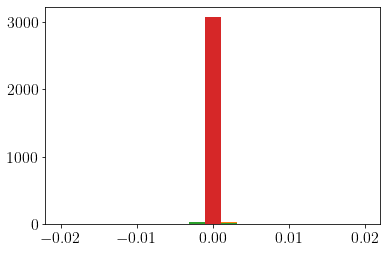

In [12]:
# just check the range of Phi_all
print(np.max(np.abs(Phi_all)))
print(np.mean(np.abs(Phi_all)))

# we need to check the computed SHAP values here. 
# the sum must add up to the difference between expected value and prediction
E = np.array(e.expected_value)

diff0 = y_conf[:,0]-np.sum(Phi_all[0,:,:], axis=1)- E[0]
diff1 = y_conf[:,1]-np.sum(Phi_all[1,:,:], axis=1)- E[1]
diff2 = y_conf[:,2]-np.sum(Phi_all[2,:,:], axis=1)- E[2]
diff3 = y_conf[:,3]-np.sum(Phi_all[3,:,:], axis=1)- E[3]

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Bookman']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 16})

# distribution of SHAP values
plt.figure()
plt.hist(diff0, bins=np.linspace(-0.02, 0.02, 20))
plt.hist(diff1, bins=np.linspace(-0.02, 0.02, 20))
plt.hist(diff2, bins=np.linspace(-0.02, 0.02, 20))
plt.hist(diff3, bins=np.linspace(-0.02, 0.02, 20))
plt.show()

# # so the additivity is not violated
# outl = Phi_all[ np.where( Phi_all > 1.0) ]
# print(outl.shape)
# Phi_corr = Phi_all
# Phi_corr[ np.where( Phi_corr > 0.1) ]=0
# Phi_all = Phi_corr

# print(diff3)

In [13]:
# now get all SHAP values per class member
Phi_30 = Phi_all[:, y_conf[:,0]==1, :]
Phi_40 = Phi_all[:, y_conf[:,1]==1, :]
Phi_50 = Phi_all[:, y_conf[:,2]==1, :]
Phi_80 = Phi_all[:, y_conf[:,3]==1, :]

# compute the frequency-wise sum of absolute SHAP values per class prediction
sum_phi_30 = np.sum(np.abs(Phi_30), axis=(0,1))
sum_phi_40 = np.sum(np.abs(Phi_40), axis=(0,1))
sum_phi_50 = np.sum(np.abs(Phi_50), axis=(0,1))
sum_phi_80 = np.sum(np.abs(Phi_80), axis=(0,1))

mean_phi_30 = np.mean(np.abs(Phi_30[:,:,:]), axis=(0,1))
mean_phi_40 = np.mean(np.abs(Phi_40[:,:,:]), axis=(0,1))
mean_phi_50 = np.mean(np.abs(Phi_50[:,:,:]), axis=(0,1))
mean_phi_80 = np.mean(np.abs(Phi_80[:,:,:]), axis=(0,1))

median_phi_30 = np.median(np.abs(Phi_30[:,:,:]), axis=(0,1))
median_phi_40 = np.median(np.abs(Phi_40[:,:,:]), axis=(0,1))
median_phi_50 = np.median(np.abs(Phi_50[:,:,:]), axis=(0,1))
median_phi_80 = np.median(np.abs(Phi_80[:,:,:]), axis=(0,1))

max_phi_30 = np.max(np.abs(Phi_30[:,:,:]), axis=(0,1))
max_phi_40 = np.max(np.abs(Phi_40[:,:,:]), axis=(0,1))
max_phi_50 = np.max(np.abs(Phi_50[:,:,:]), axis=(0,1))
max_phi_80 = np.max(np.abs(Phi_80[:,:,:]), axis=(0,1))

std_phi_30 = np.std(np.abs(Phi_30[:,:,:]), axis=(0,1))
std_phi_40 = np.std(np.abs(Phi_40[:,:,:]), axis=(0,1))
std_phi_50 = np.std(np.abs(Phi_50[:,:,:]), axis=(0,1))
std_phi_80 = np.std(np.abs(Phi_80[:,:,:]), axis=(0,1))

y_conf.shape

(3072, 4)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


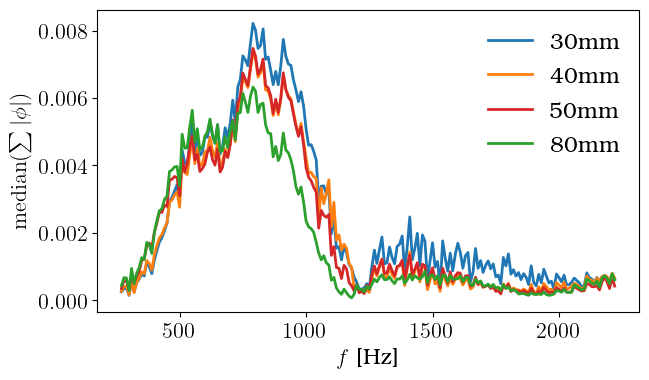

In [14]:
# plot the sums over f
plt.rcParams.update({'font.size': 16})
rc('font',**{'family':'serif','serif':['Bookman']})
rc('text', usetex=True)


plt.figure(num=None, figsize=(7, 4), dpi=100, facecolor='w')
plt.plot(f, median_phi_30, color='tab:blue', label='30mm', linewidth=2)
plt.plot(f, median_phi_40, color='tab:orange', label='40mm', linewidth=2)
plt.plot(f, median_phi_50, color='tab:red', label='50mm', linewidth=2)
plt.plot(f, median_phi_80, color='tab:green', label='80mm', linewidth=2)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\mathrm{median }(\sum |\mathbf{\phi} |)$')
plt.legend(frameon=False)
plt.savefig('./'+cur_path + '/SHAP_explanation_global_thickness.png') 
plt.savefig('./'+cur_path + '/SHAP_explanation_global_thickness.pdf', bbox_inches='tight') 
plt.show()

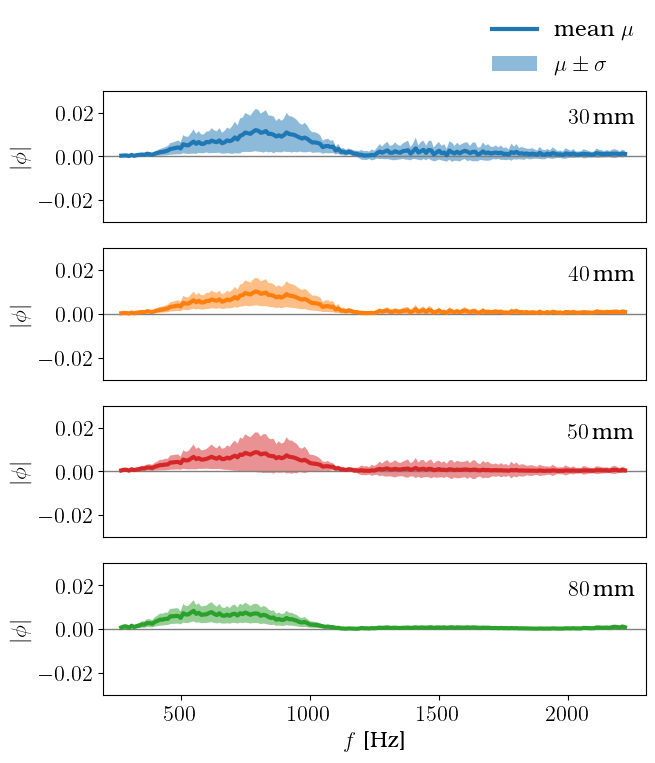

In [15]:
plt.rcParams.update({'font.size': 16})
rc('font',**{'family':'serif','serif':['Bookman']})
rc('text', usetex=True)

plt.figure(num=None, figsize=(7, 8), dpi=100, facecolor='w')

plt.subplot(4,1,1)
plt.plot([0,3000], [0,0], color='gray', linewidth=1)
plt.plot(f, mean_phi_30, color='tab:blue', label='mean $\mu$', linewidth=3)
plt.fill_between(f, mean_phi_30+std_phi_30, mean_phi_30-std_phi_30, facecolor='tab:blue', alpha=0.5, label='$\mu \pm \sigma$')
plt.ylim([-0.03, 0.03])
plt.yticks([-0.02, 0, 0.02])
plt.xticks([])
plt.xlim([200, 2300])
plt.ylabel(r'$\left| \mathbf{\phi} \right|$')
plt.legend( bbox_to_anchor=(0.68, 1.7), loc='upper left',frameon=False)
plt.text(2000, 0.015, '$30\,$mm')

plt.subplot(4,1,2)
plt.plot([0,3000], [0,0], color='gray', linewidth=1)
plt.plot(f, mean_phi_40, color='tab:orange', label='pc', linewidth=3)
plt.fill_between(f, mean_phi_40+std_phi_40, mean_phi_40-std_phi_40, facecolor='tab:orange', alpha=0.5)
plt.ylim([-0.03, 0.03])
plt.yticks([-0.02, 0, 0.02])
plt.xticks([])
plt.xlim([200, 2300])
plt.ylabel(r'$\left| \mathbf{\phi} \right|$')
plt.text(2000, 0.015, '$40\,$mm')

plt.subplot(4,1,3)
plt.plot([0,3000], [0,0], color='gray', linewidth=1)
plt.plot(f, mean_phi_50, color='tab:red', label='pc', linewidth=3)
plt.fill_between(f, mean_phi_50+std_phi_50, mean_phi_50-std_phi_50, facecolor='tab:red', alpha=0.5)
plt.ylim([-0.03, 0.03])
plt.yticks([-0.02, 0, 0.02])
plt.xticks([])
plt.xlim([200, 2300])
plt.ylabel(r'$\left| \mathbf{\phi} \right|$')
plt.text(2000, 0.015, '$50\,$mm')

plt.subplot(4,1,4)
plt.plot([0,3000], [0,0], color='gray', linewidth=1)
plt.plot(f, mean_phi_80, color='tab:green', label='pc', linewidth=3)
plt.fill_between(f, mean_phi_80+std_phi_80, mean_phi_80-std_phi_80, facecolor='tab:green', alpha=0.5)
plt.ylim([-0.03, 0.03])
plt.yticks([-0.02, 0, 0.02])
plt.ylabel(r'$\left| \mathbf{\phi} \right|$')
plt.text(2000, 0.015, '$80\,$mm')
plt.xlim([200, 2300])
plt.xlabel(r'$f$ [Hz]')
plt.savefig('./'+cur_path + '/SHAP_explanation_global_detail.png') 
plt.savefig('./'+cur_path + '/SHAP_explanation_global_detail.pdf', bbox_inches='tight') 
plt.show()